# Code repository for producing results

reference : [The minute-scale dynamics of online emotions reveal the effects of affect labeling]() by Rui Fan, Onur Varol, Ali Varamesh, Alexander Barron, Ingrid van de Leemput, Marten Scheffer, and Johan Bollen



In [1]:
%matplotlib inline 

import glob
import numpy as np
import scipy as sp

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import pandas as pd

from scipy import stats
from scipy.optimize import curve_fit

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from lmfit.models import *
from sklearn.mixture import GaussianMixture


In [2]:
# Folder for intermediary files created by processing raw tweet files. 
DATA_PATH = 'data/intermediary_data/new_data/'


# Volume graph 

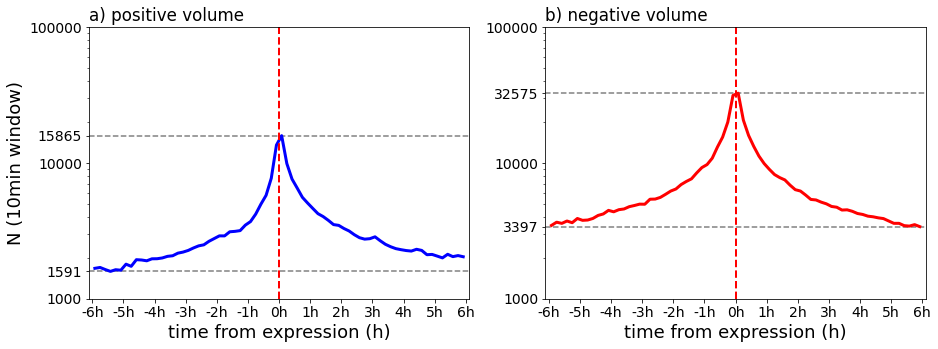

In [5]:
# Read positive and negative valence timeseries VADER and null-models
pos_all = pd.read_csv("{}pos_reply_status=all.txt".format(DATA_PATH), sep="\t")
neg_all = pd.read_csv("{}neg_reply_status=all.txt".format(DATA_PATH), sep="\t")

plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams.update({'font.size': 14})

datasets = [pos_all, neg_all]
labels = ["a) positive volume", "b) negative volume" ]
colors = ["blue", "red"]

fig, axes = plt.subplots(1, 2)
for i in range(len(axes)):
    data = datasets[i]
    label = labels[i]
    color = colors[i]
    
    # set up axes and labels
    axes[i].set_xlim([-22000, 22000])
    axes[i].set_xlabel("time from expression (h)", fontsize=18)
    
    if i == 0:
        axes[i].set_ylabel("N (10min window)", fontsize=18)
    axes[i].set_title(label, loc="left")
    axes[i].set_yscale('log')
    
    # determine max and min
    nmax = np.max(data["lengths"])
    nmin = np.min(data["lengths"])
    axes[i].set_ylim(nmin*0.85,nmax*1.25)
    
    # add horizontal line
    axes[i].axhline(y=nmax, color="gray",linestyle="--")
    axes[i].axhline(y=nmin,color="gray",linestyle="--")
           
    plt.sca(axes[i])
    plt.xticks([i*60*60 for i in range(-6,7)], [str(i)+'h' for i in range(-6,7)])
    
    axes[i].plot(data["window"], data["lengths"], linewidth=3, label="volume", color=color)
    axes[i].axvline(x=0, color="red", linestyle="--", linewidth=2)
    #axes[i].grid(which="both")
    
    axes[i].set_yticks([1000, nmin, 10000, nmax,100000])
    axes[i].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
fig.savefig('%sfigures/tweet_volume_windowt.pdf'% DATA_PATH  , bbox_inches='tight')


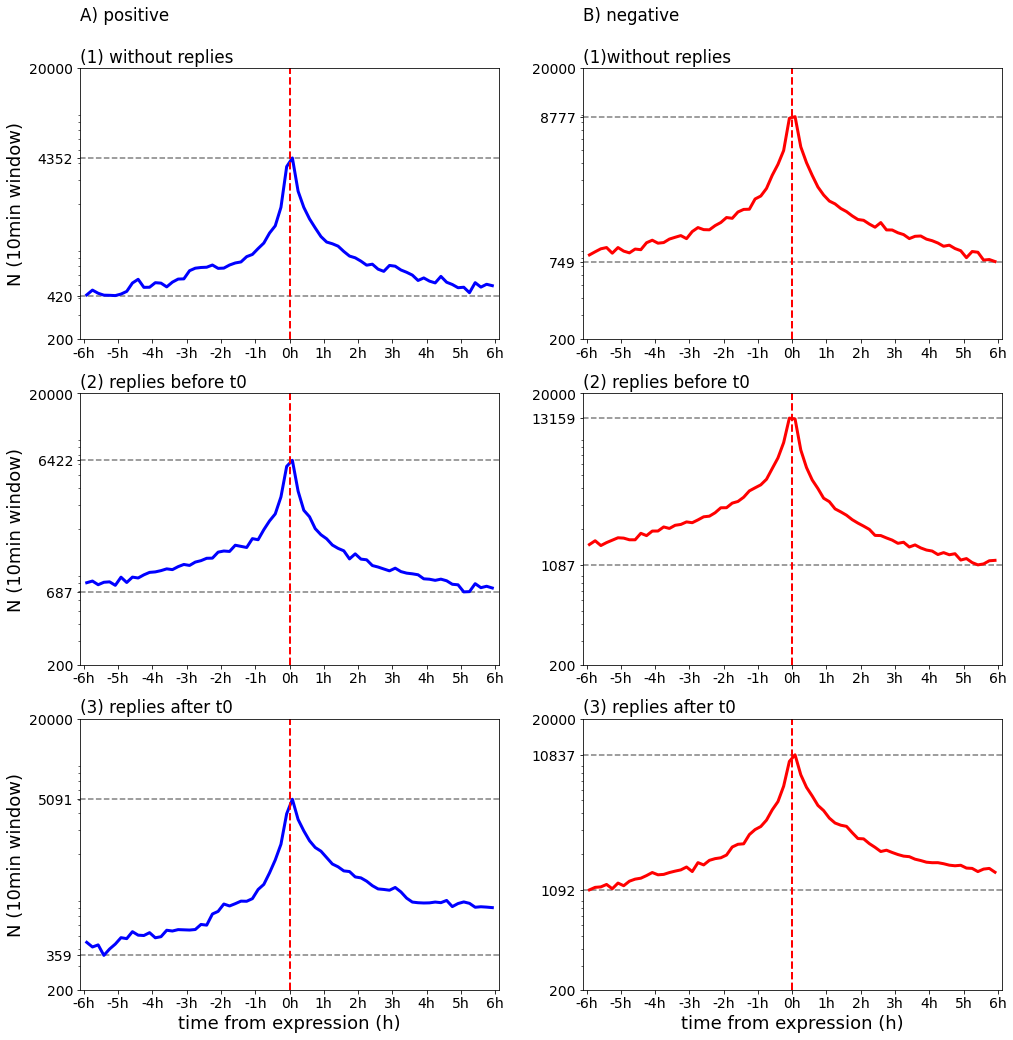

In [6]:
files = ['pos_reply_status=none.txt',\
         'neg_reply_status=none.txt',\
         'pos_reply_status=before.txt',\
         'neg_reply_status=before.txt',\
        "pos_reply_status=after.txt",\
        "neg_reply_status=after.txt"]

pos_none = pd.read_csv(DATA_PATH+files[0], sep="\t")
neg_none= pd.read_csv(DATA_PATH+files[1], sep="\t")
pos_before= pd.read_csv(DATA_PATH+files[2], sep="\t")
neg_before = pd.read_csv(DATA_PATH+files[3], sep="\t")
pos_after= pd.read_csv(DATA_PATH+files[4], sep="\t")
neg_after= pd.read_csv(DATA_PATH+files[5], sep="\t")


plt.rcParams['figure.figsize'] = (16.0, 16.0)
plt.rcParams.update({'font.size': 14})
plt.rcParams["legend.loc"] = 'lower center' 
datasets = [pos_none, neg_none, pos_before, neg_before,pos_after,neg_after]

labels = ["A) positive\n\n(1) without replies", "B) negative\n\n(1)without replies",
          "(2) replies before t0",   "(2) replies before t0",
         "(3) replies after t0", "(3) replies after t0"]

colors = ["blue", "red"]

fig, axes = plt.subplots(3, 2)
for i, ax in enumerate([axes[0][0], axes[0][1],  axes[1][0], axes[1][1], axes[2][0], axes[2][1]]):      
    
    data = datasets[i]
    label = labels[i]
    color = colors[i % 2]
    
    # set up axes and labels
    ax.set_xlim([-22000, 22000])
    if i in [5,4]:
        ax.set_xlabel("time from expression (h)", fontsize=18)
    
    if i % 2 == 0:
        ax.set_ylabel("N (10min window)", fontsize=18)
    ax.set_title(label, loc="left")
    ax.set_yscale('log')
    
    # determine max and min
    nmax = np.max(data["lengths"])
    nmin = np.min(data["lengths"])
    ax.set_ylim(nmin*0.85,nmax*1.25)
    
    # add horizontal line
    ax.axhline(y=nmax, color="gray",linestyle="--")
    ax.axhline(y=nmin,color="gray",linestyle="--")
           
    plt.sca(ax)
    plt.xticks([i*60*60 for i in range(-6,7)], [str(i)+'h' for i in range(-6,7)])
    
    ax.plot(data["window"], data["lengths"], linewidth=3, label="volume", color=color)
    ax.axvline(x=0, color="red", linestyle="--", linewidth=2)
    #axes[i].grid(which="both")
    
    ax.set_yticks([200, nmin, nmax,20000])
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, )

fig.savefig('%sfigures/tweet_volume_windowt_reply_status.pdf'% DATA_PATH  , bbox_inches='tight')
    

**Supplementary Figure 2 Number of tweets per time window.** We observe significantly higher volumes of tweets across our sample of individuals closer to the time of affect labeling.  (a) The sample of tweets in the positive group ranges from a minimum of 1,971 to a maximum of 19,863 tweets. (b) The sample of tweets in the negative group ranges from a minimum of 4,431 to a maximum of 41,622 tweets. Note that we find a significant larger volume of tweets in the negative group vs. the positive group.

# CUSUM Analysis

In [7]:
def find_abnormal(data, mean, k):
    # find abnormal values
    N = len(data)
    smax, smin = 0, 0
    maxs, mins = [], []
    for i in range(N):
        new_max = max(0, smax+data[i]-mean-k)
        new_min = min(0, smin+data[i]-mean+k)
        smin = new_min
        smax = new_max
        maxs.append(smax)
        mins.append(smin)
    return maxs, mins

def find_abnormal_max(maxs, H, len_sub_seq):
    # find continuous abnormal values
    l_max_abnormals = []
    i = 0
    while i < len(maxs):
        j = i
        while j < len(maxs):
            if maxs[j] > H:
                break
            j += 1
        abnormals = [j]
        while j+1 < len(maxs) and maxs[j] < maxs[j+1]:
            j += 1
            abnormals.append(j)
        j += 1
        i = j
        if len(abnormals) >= len_sub_seq:
            l_max_abnormals.append(abnormals)
    return l_max_abnormals

def find_abnormal_min(mins, H, len_sub_seq):
    # find continuous abnormal values
    l_min_abnormals = []
    i = 0
    while i < len(mins):
        j = i
        while j < len(mins):
            if mins[j] < -H:
                break
            j += 1
        abnormals = [j]
        while j+1 < len(mins) and mins[j] > mins[j+1]:
            j += 1
            abnormals.append(j)
        j += 1
        i = j
        if len(abnormals) >= len_sub_seq:
            l_min_abnormals.append(abnormals)
    return l_min_abnormals

Mean value a) positive: 0.13
a) positive CUSUM: max:  -2520.0 s-  3180.0 s
Mean value b) negative: 0.11
b) negative CUSUM: max:  -3900.0 s-  540.0 s


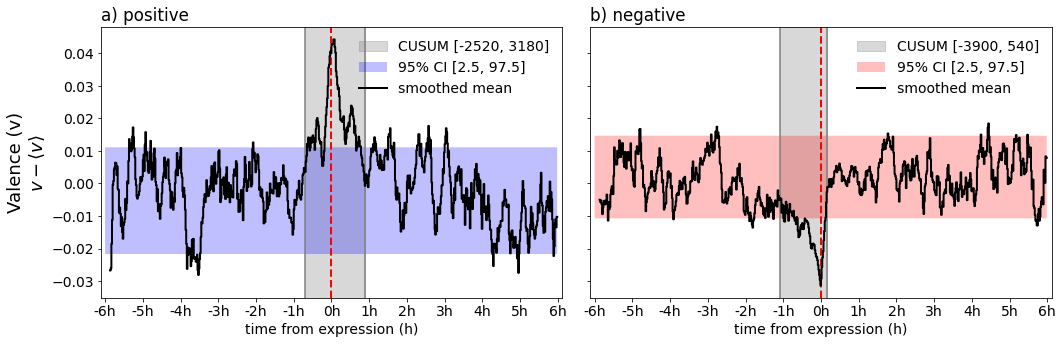

In [81]:
# Read mean valence time series
mood_pos_all = pd.read_csv("{}mean_mood=1_reply_status=all.txt".format(DATA_PATH), sep="\t")
mood_neg_all = pd.read_csv("{}mean_mood=-1_reply_status=all.txt".format(DATA_PATH), sep="\t")

# set figure size parameters
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams.update({'font.size': 14})

# changing graph parameters
datasets = [mood_pos_all,mood_neg_all]
labels = ["a) positive", "b) negative" ]
colors = ["blue", "red"]

fig, axes = plt.subplots(1,2, sharey=True)
for i in range(len(axes)):
    
    # get plotting parameters
    data = datasets[i]
    label = labels[i]
    color = colors[i]
    
    # set up graph labels and axes
    axes[i].set_title(label, loc="left")
    
    # set axis limits and labels
    axes[i].set_xlim([-22000, +22000])
    axes[i].set_xlabel("time from expression (h)")
    if i == 0:
        axes[i].set_ylabel("Valence (v)\n" + r"$v - \left \langle v \right \rangle$", fontsize=18)
    
    #set tick marks to 3600s = an hour
    plt.sca(axes[i])
    plt.xticks([i*60*60 for i in range(-6,7)], [str(i)+'h' for i in range(-6,7)])
        
    mean_smoothed = data["mean"]\
     .rolling(window=10).mean()
    print('Mean value {}: {:.2f}'.format(labels[i], data["mean"].mean()))
    mean_smoothed -= np.mean(mean_smoothed)
        
    # CUSUM mark emotional period
    mean, std = np.mean(mean_smoothed.iloc[-180:]), np.std(mean_smoothed.iloc[-180:]) #???
    maxs, mins = find_abnormal(mean_smoothed, mean, std)
    
    if i == 0:
        abnormal_points = find_abnormal_max(maxs, 0.01, 40)
    else:
        abnormal_points = find_abnormal_min(mins, 0.01, 40)
        
    cusum_start = data.iloc[min(list(abnormal_points[0]))]["start"]
    cusum_end = data.iloc[max(list(abnormal_points[0]))]["start"]
    print(label, "CUSUM: max: ", cusum_start, "s- ", cusum_end, "s")
    cusumlabel = "CUSUM [{}, {}]".format(int(cusum_start), int(cusum_end))
    axes[i].axvspan(cusum_start, cusum_end, alpha=0.3, color='gray', label=cusumlabel)
    axes[i].axvline(x=cusum_start, color="gray")
    axes[i].axvline(x=cusum_end, color="gray")
    axes[i].axvline(x=0, color="red", linestyle="--", linewidth=2)
    
    # CI BAND: mark horizontal bamd of percentiles of magnitude of SMOOTHED time series
    plow, phigh = 2.5,97.5
    band_low, ts_median, band_high = np.nanpercentile(mean_smoothed.iloc[-180:], plow),\
                                     np.nanpercentile(mean_smoothed.iloc[-180:], 50.0),\
                                     np.nanpercentile(mean_smoothed.iloc[-180:], phigh)
            
    axes[i].fill_between(data["start"], band_low, band_high, 
                         alpha=0.25, facecolor=color,
                         label="95% CI [{}, {}]".format(plow,phigh), 
                         step="mid")
    
    axes[i].step(data["start"], mean_smoothed,\
            color="black", linewidth=2, 
            label="smoothed mean")
    axes[i].legend(frameon=False, prop={'size': 14})

plt.tight_layout()
fig.savefig('%sfigures/posneg_all_1minute_CUSUM.pdf'% DATA_PATH, bbox_inches='tight')
fig.savefig('%sfigures/Fig2.pdf' % DATA_PATH, bbox_inches='tight')


Mean value A) positive

(1) without replies: 0.13
A) positive

(1) without replies CUSUM: max:  -900.0 s-  1980.0 s
percentiles:  -0.052306747921940906 -0.015766900421940913 0.016229032078059098
Mean value B) negative

(1)without replies: 0.11
NO CUSUM
percentiles:  -0.0294506741455697 0.002298968354430289 0.02520227835443031
Mean value (2) replies before t0: 0.13
(2) replies before t0 CUSUM: max:  -1560.0 s-  2640.0 s
percentiles:  -0.03233370399085795 -0.010528791490857954 0.017351276009142044
Mean value (2) replies before t0: 0.11
(2) replies before t0 CUSUM: max:  -2100.0 s-  480.0 s
percentiles:  -0.01747849234177222 0.0008457626582277847 0.02935808015822779
Mean value (3) replies after t0: 0.14
(3) replies after t0 CUSUM: max:  -360.0 s-  2340.0 s
percentiles:  -0.03340897143108279 -0.002427808931082784 0.026080731068917215
Mean value (3) replies after t0: 0.12
(3) replies after t0 CUSUM: max:  -2580.0 s-  300.0 s
percentiles:  -0.017787980731364332 0.0012794692686356746 0.021095

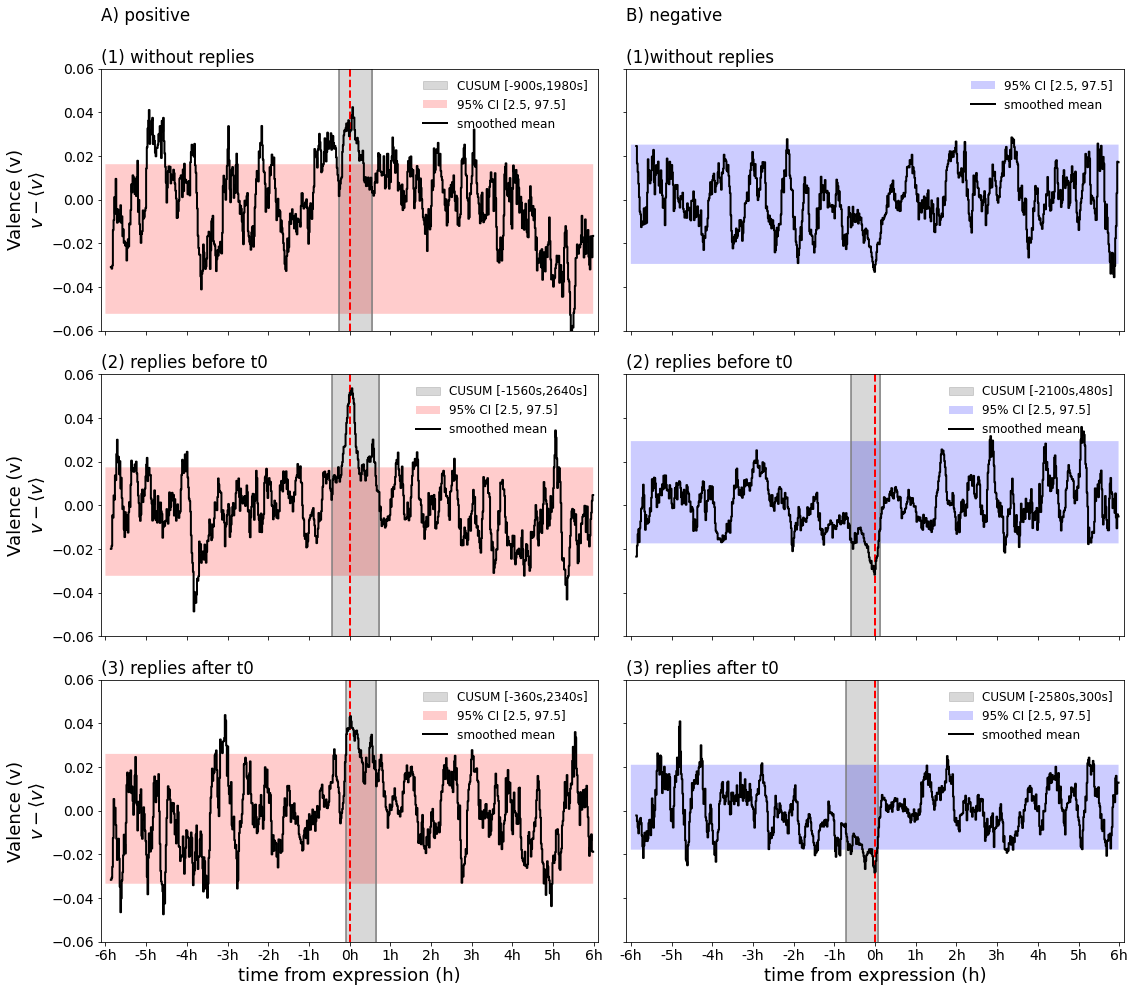

In [8]:
plt.rcParams['figure.figsize'] = (16.0, 14.0)
plt.rcParams.update({'font.size': 14})
plt.rcParams["legend.loc"] = 'upper right' 
files = ['mean_mood=1_reply_status=none.txt',\
         'mean_mood=-1_reply_status=none.txt',\
         'mean_mood=1_reply_status=before.txt',\
         'mean_mood=-1_reply_status=before.txt',\
        "mean_mood=1_reply_status=after.txt",\
        "mean_mood=-1_reply_status=after.txt"]

mood_pos_none = pd.read_csv(DATA_PATH+files[0], sep="\t")
mood_neg_none= pd.read_csv(DATA_PATH+files[1], sep="\t")
mood_pos_before= pd.read_csv(DATA_PATH+files[2], sep="\t")
mood_neg_before = pd.read_csv(DATA_PATH+files[3], sep="\t")
mood_pos_after= pd.read_csv(DATA_PATH+files[4], sep="\t")
mood_neg_after= pd.read_csv(DATA_PATH+files[5], sep="\t")

datasets = [mood_pos_none, mood_neg_none, mood_pos_before, mood_neg_before,mood_pos_after,mood_neg_after]
labels = ["A) positive\n\n(1) without replies", "B) negative\n\n(1)without replies",
          "(2) replies before t0",   "(2) replies before t0",
         "(3) replies after t0", "(3) replies after t0"]

fig, axes = plt.subplots(3, 2, sharex=True, sharey=True)
for i,ax in enumerate([axes[0][0], axes[0][1],  axes[1][0], axes[1][1], axes[2][0], axes[2][1]]):

    data = datasets[i]
    label = labels[i]
    color = ['red' if i % 2 ==0   else 'blue']
    
    # set up graph labels and axes
    ax.set_title(label, loc="left")
    
    # set axis limits and labels
    ax.set_xlim([-22000, 22000])
    if i in [4,5]:
        ax.set_xlabel("time from expression (h)", fontsize=18)
    if i in [0,2,4]:
        ax.set_ylabel("Valence (v)\n" + r"$v - \left \langle v \right \rangle$", fontsize=18)
    
    plt.sca(ax)
    plt.xticks([i*60*60 for i in range(-6,7)], [str(i)+'h' for i in range(-6,7)])
    
    ax.set_ylim([-0.06,0.06])    
    
    mean_smoothed = data["mean"].rolling(window= 10).mean()
    print('Mean value {}: {:.2f}'.format(labels[i], data["mean"].mean()))
    mean_smoothed -= np.mean(mean_smoothed)
        
    # emotional period indication based on CUSUM
    mean, std = np.mean(mean_smoothed.iloc[-180:]), np.std(mean_smoothed.iloc[-180:])
    maxs, mins = find_abnormal(mean_smoothed, mean, std)
    
    if i % 2 == 0:
        abnormal_points = find_abnormal_max(maxs, 0.01, 40)
    else:
        abnormal_points = find_abnormal_min(mins, 0.01, 40)
    try:    
        cusum_start = data.iloc[min(list(abnormal_points[0]))]["start"]
        cusum_end = data.iloc[max(list(abnormal_points[0]))]["start"]
        print(label, "CUSUM: max: ", cusum_start, "s- ", cusum_end, "s")
        cusumlabel = "CUSUM ["+str(int(cusum_start))+"s,"+str(int(cusum_end))+"s]"

        ax.axvspan(cusum_start, cusum_end, alpha=0.3, color='gray', label=cusumlabel)
        ax.axvline(x=cusum_start, color="gray")
        ax.axvline(x=cusum_end, color="gray")
        ax.axvline(x=0, color="red", linestyle="--", linewidth=2)
    except:
        print("NO CUSUM")
    # indicate band of percentiles of magnitude of SMOOTHED time series
    plow, phigh = 2.5,97.5
    band_low, ts_median, band_high = np.nanpercentile(mean_smoothed.iloc[-180:], plow),\
                                     np.nanpercentile(mean_smoothed.iloc[-180:], 50.0),\
                                     np.nanpercentile(mean_smoothed.iloc[-180:], phigh)
            
    print("percentiles: ", band_low, ts_median, band_high)
    ax.fill_between(data["start"], band_low, band_high,
                    alpha=0.2, facecolor=color,
                    label="95% CI [{}, {}]".format(plow, phigh), step="mid")
      
    ax.step(data["start"], mean_smoothed,
            color="black", linewidth=2, label="smoothed mean")
    
    ax.legend(frameon=False, prop={'size': 12},)

plt.tight_layout()
fig.savefig('%sfigures/posneg_reply_status_CUSUM.pdf' %DATA_PATH, bbox_inches='tight')
fig.savefig('%sfigures/FigS2.pdf' %DATA_PATH, bbox_inches='tight')


Mean value A) positive

(1) replies before t0: 0.13
A) positive

(1) replies before t0 CUSUM: max:  -1560.0 s-  2640.0 s
percentiles:  -0.03233370399085795 -0.010528791490857954 0.017351276009142044
Mean value B) negative

(1)replies before t0: 0.11
B) negative

(1)replies before t0 CUSUM: max:  -2100.0 s-  480.0 s
percentiles:  -0.01747849234177222 0.0008457626582277847 0.02935808015822779
Mean value (2) replies before t0 with replies after t0: 0.13
(2) replies before t0 with replies after t0 CUSUM: max:  -2280.0 s-  2400.0 s
percentiles:  -0.035328552021800415 -0.00890408952180042 0.019284160478199596
Mean value (2) replies before t0 with replies after t0: 0.11
(2) replies before t0 with replies after t0 CUSUM: max:  -2160.0 s-  420.0 s
percentiles:  -0.018877563301687782 0.0018132691983122201 0.03026455169831223


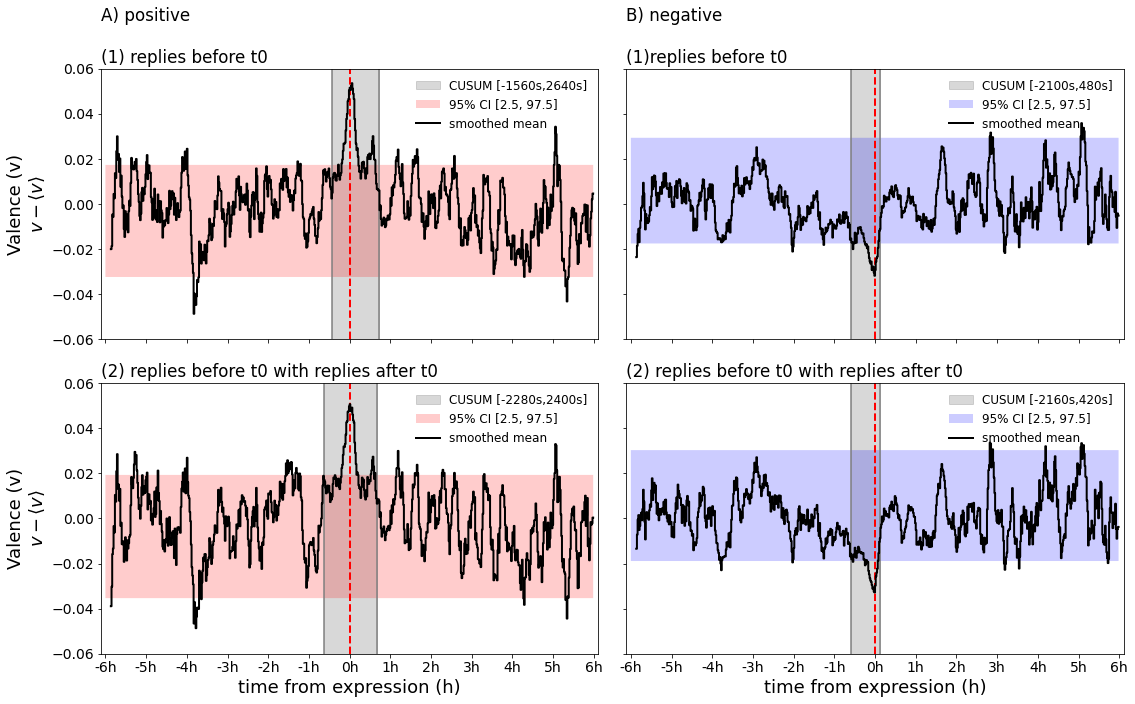

In [9]:
plt.rcParams['figure.figsize'] = (16.0, 10.0)
plt.rcParams.update({'font.size': 14})
plt.rcParams["legend.loc"] = 'upper right' 
files = ['mean_mood=1_reply_status=before.txt',\
         'mean_mood=-1_reply_status=before.txt',\
         'mean_mood=1_reply_status=before_after.txt',\
         'mean_mood=-1_reply_status=before_after.txt']

mood_pos_none = pd.read_csv(DATA_PATH+files[0], sep="\t")
mood_neg_none= pd.read_csv(DATA_PATH+files[1], sep="\t")
mood_pos_before= pd.read_csv(DATA_PATH+files[2], sep="\t")
mood_neg_before = pd.read_csv(DATA_PATH+files[3], sep="\t")


datasets = [mood_pos_none, mood_neg_none, mood_pos_before, mood_neg_before,mood_pos_after,mood_neg_after]
labels = ["A) positive\n\n(1) replies before t0", "B) negative\n\n(1)replies before t0",
          "(2) replies before t0 with replies after t0",   "(2) replies before t0 with replies after t0"]

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
for i,ax in enumerate([axes[0][0], axes[0][1],  axes[1][0], axes[1][1]]):

    data = datasets[i]
    label = labels[i]
    color = ['red' if i % 2 ==0   else 'blue']
    
    # set up graph labels and axes
    ax.set_title(label, loc="left")
    
    # set axis limits and labels
    ax.set_xlim([-22000, 22000])
    if i in [2,3]:
        ax.set_xlabel("time from expression (h)", fontsize=18)
    if i in [0,2,4]:
        ax.set_ylabel("Valence (v)\n" + r"$v - \left \langle v \right \rangle$", fontsize=18)
    
    plt.sca(ax)
    plt.xticks([i*60*60 for i in range(-6,7)], [str(i)+'h' for i in range(-6,7)])
    
    ax.set_ylim([-0.06,0.06])    
    
    mean_smoothed = data["mean"].rolling(window= 10).mean()
    print('Mean value {}: {:.2f}'.format(labels[i], data["mean"].mean()))
    mean_smoothed -= np.mean(mean_smoothed)
        
    # emotional period indication based on CUSUM
    mean, std = np.mean(mean_smoothed.iloc[-180:]), np.std(mean_smoothed.iloc[-180:])
    maxs, mins = find_abnormal(mean_smoothed, mean, std)
    
    if i % 2 == 0:
        abnormal_points = find_abnormal_max(maxs, 0.01, 40)
    else:
        abnormal_points = find_abnormal_min(mins, 0.01, 40)
    try:    
        cusum_start = data.iloc[min(list(abnormal_points[0]))]["start"]
        cusum_end = data.iloc[max(list(abnormal_points[0]))]["start"]
        print(label, "CUSUM: max: ", cusum_start, "s- ", cusum_end, "s")
        cusumlabel = "CUSUM ["+str(int(cusum_start))+"s,"+str(int(cusum_end))+"s]"

        ax.axvspan(cusum_start, cusum_end, alpha=0.3, color='gray', label=cusumlabel)
        ax.axvline(x=cusum_start, color="gray")
        ax.axvline(x=cusum_end, color="gray")
        ax.axvline(x=0, color="red", linestyle="--", linewidth=2)
    except:
        print("NO CUSUM")
    # indicate band of percentiles of magnitude of SMOOTHED time series
    plow, phigh = 2.5,97.5
    band_low, ts_median, band_high = np.nanpercentile(mean_smoothed.iloc[-180:], plow),\
                                     np.nanpercentile(mean_smoothed.iloc[-180:], 50.0),\
                                     np.nanpercentile(mean_smoothed.iloc[-180:], phigh)
            
    print("percentiles: ", band_low, ts_median, band_high)
    ax.fill_between(data["start"], band_low, band_high,
                    alpha=0.2, facecolor=color,
                    label="95% CI [{}, {}]".format(plow, phigh), step="mid")
      
    ax.step(data["start"], mean_smoothed,
            color="black", linewidth=2, label="smoothed mean")
    
    ax.legend(frameon=False, prop={'size': 12},)

plt.tight_layout()
fig.savefig('%sfigures/posneg_reply_status_CUSUM_supply.pdf' %DATA_PATH, bbox_inches='tight')
# fig.savefig('%sfigures/FigS2.pdf' %DATA_PATH, bbox_inches='tight')


# Analyzing confidence intervals of observations and null-model


 a) positive valence
Vader mean:0.13 | Null mean:0.13
max window_end a) positive valence : -300 s
min window_end a) positive valence : -12900 s
> NULL:
 35   -300
36    300
37    900
Name: window, dtype: int64
< NULL
 Series([], Name: window, dtype: int64)

 b) negative valence
Vader mean:0.11 | Null mean:0.11
max window_end b) negative valence : 19500 s
min window_end b) negative valence : -300 s
> NULL:
 Series([], Name: window, dtype: int64)
< NULL
 34   -900
35   -300
Name: window, dtype: int64


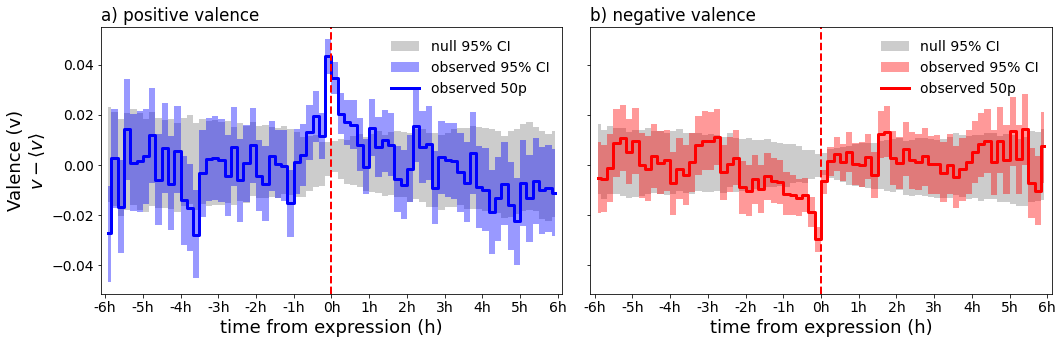

In [10]:
# set figure size parameters
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams.update({'font.size': 14})

# Read positive and negative valence timeseries VADER and null-models
pos_all = pd.read_csv("{}pos_reply_status=all.txt".format(DATA_PATH), sep="\t")
neg_all = pd.read_csv("{}neg_reply_status=all.txt".format(DATA_PATH), sep="\t")

datasets = [pos_all, neg_all]
labels = ["a) positive valence", "b) negative valence" ]
colors = ["blue", "red"]

fig, axes = plt.subplots(1,2, sharey=True)
for i in range(len(axes)):
    
    data = datasets[i]
    label = labels[i]
    color = colors[i]
    
    # Mean difference
    meanVader = data["vader_50p"].mean()
    data["vader_50p"] -= meanVader
    data["vader_2.5p"] -= meanVader
    data["vader_97.5p"] -= meanVader
    meanNull = data["null_50p"].mean()
    data["null_50p"] -= meanNull
    data["null_2.5p"] -= meanNull
    data["null_97.5p"] -= meanNull

    # get index of maximum value
    maxv = np.argmax(data["vader_50p"].values)
    minv = np.argmin(data["vader_50p"].values)
    
    #### EMOTIONAL PERIOD BASED ON NON-OVERLAPPING CI
    # find area where CIs don't overlap, i.e. where vader_2.5p > null_97.5p
    # or where vader_97.5p < null_2.5p
    print("\n", label)
    print('Vader mean:{:.2f} | Null mean:{:.2f}'.format(meanVader, meanNull))
    print("max window_end", label, ":", data["window"].iloc[maxv], "s")
    print("min window_end", label, ":", data["window"].iloc[minv], "s")
    print("> NULL:\n", data[data["vader_2.5p"] > data["null_97.5p"]]["window"])
    print("< NULL\n", data[data["vader_97.5p"] < data["null_2.5p"]]["window"])

    # set up graph labels and axes
    axes[i].set_title(label, loc="left")
    
    # set axis limits and labels
    axes[i].set_xlim([-22000, +22000])
    axes[i].set_xlabel("time from expression (h)", fontsize=18)
    if i == 0:
        axes[i].set_ylabel("Valence (v)\n" + r"$v - \left \langle v \right \rangle$", fontsize=18)
    
    #set tick marks to 3600s = an hour
    plt.sca(axes[i])
    plt.xticks([i*60*60 for i in range(-6,7)], [str(i)+'h' for i in range(-6,7)])
    
    ## TIME SERIES
    # null bands and lines
    axes[i].fill_between(data["window"], data["null_2.5p"], data["null_97.5p"],
                         alpha=0.4, facecolor='gray', label="null 95% CI", step="mid")

    # valence bands and lines
    axes[i].fill_between(data["window"], data["vader_2.5p"], data["vader_97.5p"],
                         alpha=0.4, facecolor=color, label="observed 95% CI", step="mid")
    axes[i].step(data["window"], data["vader_50p"],
                 color=color, linewidth=3, label="observed 50p", where='mid')
    
    #axes[i].grid(which='both')
    axes[i].axvline(x=0, color="red", linestyle="--", linewidth=2)
    
    axes[i].legend(frameon=False, prop={'size': 14})
    
plt.tight_layout()
    
#fig.savefig('figures/posneg_all_10minute_KS.pdf', bbox_inches='tight')
# fig.savefig('figures/FigS4.pdf', bbox_inches='tight')

[A) positive

(1) without replies] Vader mean:0.13 | Null mean:0.13
max window_end A) positive

(1) without replies : -17700 s
min window_end A) positive

(1) without replies : 19500 s
A) positive

(1) without replies 

> NULL:
 35   -300
36    300
Name: window, dtype: int64
< NULL
 Series([], Name: window, dtype: int64)
[B) negative

(1)without replies] Vader mean:0.11 | Null mean:0.11
max window_end B) negative

(1)without replies : 19500 s
min window_end B) negative

(1)without replies : 20700 s
B) negative

(1)without replies 

> NULL:
 Series([], Name: window, dtype: int64)
< NULL
 35   -300
Name: window, dtype: int64
[(2) replies before t0] Vader mean:0.13 | Null mean:0.13
max window_end (2) replies before t0 : -300 s
min window_end (2) replies before t0 : 18900 s
(2) replies before t0 

> NULL:
 35   -300
36    300
Name: window, dtype: int64
< NULL
 Series([], Name: window, dtype: int64)
[(2) replies before t0] Vader mean:0.11 | Null mean:0.11
max window_end (2) replies before t

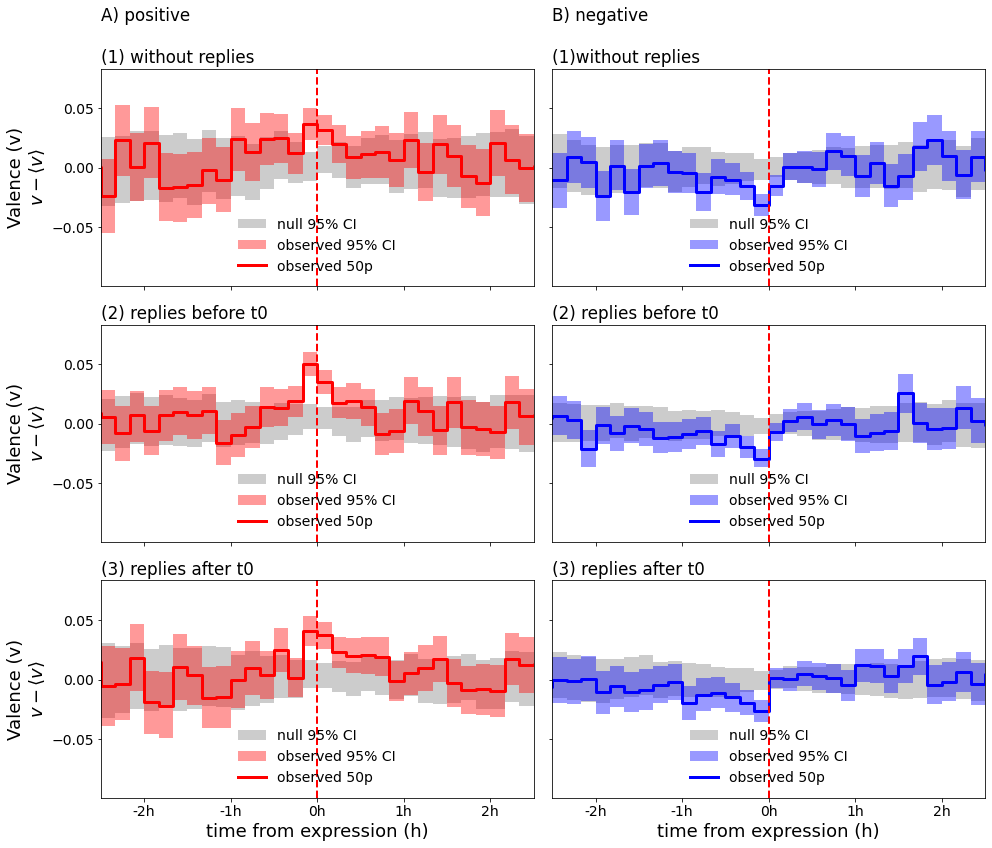

In [11]:
files = ['pos_reply_status=none.txt',\
         'neg_reply_status=none.txt',\
         'pos_reply_status=before.txt',\
         'neg_reply_status=before.txt',\
        "pos_reply_status=after.txt",\
        "neg_reply_status=after.txt"]

pos_none = pd.read_csv(DATA_PATH+files[0], sep="\t")
neg_none= pd.read_csv(DATA_PATH+files[1], sep="\t")
pos_before= pd.read_csv(DATA_PATH+files[2], sep="\t")
neg_before = pd.read_csv(DATA_PATH+files[3], sep="\t")
pos_after= pd.read_csv(DATA_PATH+files[4], sep="\t")
neg_after= pd.read_csv(DATA_PATH+files[5], sep="\t")

plt.rcParams['figure.figsize'] = (14.0, 12.0)
plt.rcParams.update({'font.size': 14})
plt.rcParams["legend.loc"] = 'lower center' 
datasets = [pos_none, neg_none, pos_before, neg_before,pos_after,neg_after]

labels = ["A) positive\n\n(1) without replies", "B) negative\n\n(1)without replies",
          "(2) replies before t0",   "(2) replies before t0",
         "(3) replies after t0", "(3) replies after t0"]

fig, axes = plt.subplots(3, 2, sharex=True, sharey=True)
for i, ax in enumerate([axes[0][0], axes[0][1],  axes[1][0], axes[1][1], axes[2][0], axes[2][1]]):  

    # get next data file from files and labels, and plot these in the present ax in axes
    data = datasets[i]
    label = labels[i]
    color = ['red' if i % 2 == 0  else 'blue']
    
    # Mean difference
    meanVader = data["vader_50p"].mean()
    data["vader_50p"] -= meanVader
    data["vader_2.5p"] -= meanVader
    data["vader_97.5p"] -= meanVader
    meanNull = data["null_50p"].mean()
    data["null_50p"] -= meanNull
    data["null_2.5p"] -= meanNull
    data["null_97.5p"] -= meanNull
    print('[{}] Vader mean:{:.2f} | Null mean:{:.2f}'.format(label, meanVader, meanNull))

    # get index of maximum value
    maxv = np.argmax(data["vader_50p"].values)
    minv = np.argmin(data["vader_50p"].values)
    
    print("max window_end", label, ":", data["window"].iloc[maxv], "s")
    print("min window_end", label, ":", data["window"].iloc[minv], "s")
    
    #### EMOTIONAL PERIOD BASED ON NON-OVERLAPPING CI
    # find area where CIs don't overlap, i.e. where vader_2.5p > null_97.5p
    # or where vader_97.5p < null_2.5p
    print(label, "\n")
    print("> NULL:\n", data[data["vader_2.5p"] > data["null_97.5p"]]["window"])
    print("< NULL\n", data[data["vader_97.5p"] < data["null_2.5p"]]["window"])

    
    # set up graph labels and axes
    ax.set_title(label, loc="left")
    
    # set axis limits and labels
    ax.set_xlim([-9000, +9000])
    if i in [4,5]:
        ax.set_xlabel("time from expression (h)", fontsize=18)
    if i % 2 == 0:
        ax.set_ylabel("Valence (v)\n" + r"$v - \left \langle v \right \rangle$", fontsize=18)
    
    #set tick marks to 3600s = an hour
    plt.sca(ax)
    plt.xticks([-7200,-3600,0,3600,7200], [str(i)+'h' for i in range(-2,3)])
    
    ## TIME SERIES
    # null bands and lines
    ax.fill_between(data["window"], data["null_2.5p"],
                         data["null_97.5p"],
                         alpha=0.4, facecolor='gray', 
                         label="null 95% CI", step="mid")

    # valence bands and lines
    ax.fill_between(data["window"],
                         data["vader_2.5p"],
                         data["vader_97.5p"],
                         alpha=0.4, facecolor=color[0], 
                         label="observed 95% CI", step="mid")
    ax.step(data["window"], data["vader_50p"],
                 color=color[0], linewidth=3, label="observed 50p", where='mid')
    
    #axes[i].grid(which='both')
    ax.axvline(x=0, color="red", linestyle="--", linewidth=2)
    ax.legend(frameon=False, prop={'size': 14})
    
plt.tight_layout()
fig.savefig('%sfigures/posneg_reply_status_10minute_KS_zoom3hr.pdf'%DATA_PATH, bbox_inches='tight')
# fig.savefig('figures/Fig4.pdf', bbox_inches='tight')


[A) positive

(1) without replies] Vader mean:0.13 | Null mean:0.13
A) positive

(1) without replies 

> NULL:
 35   -300
36    300
Name: window, dtype: int64
< NULL
 Series([], Name: window, dtype: int64)
[B) negative

(1)without replies] Vader mean:0.11 | Null mean:0.11
B) negative

(1)without replies 

> NULL:
 Series([], Name: window, dtype: int64)
< NULL
 35   -300
Name: window, dtype: int64
[(2) replies before t0] Vader mean:0.13 | Null mean:0.13
(2) replies before t0 

> NULL:
 35   -300
36    300
Name: window, dtype: int64
< NULL
 Series([], Name: window, dtype: int64)
[(2) replies before t0] Vader mean:0.11 | Null mean:0.11
(2) replies before t0 

> NULL:
 Series([], Name: window, dtype: int64)
< NULL
 34   -900
35   -300
Name: window, dtype: int64
[(3) replies after t0] Vader mean:0.14 | Null mean:0.13
(3) replies after t0 

> NULL:
 35   -300
36    300
Name: window, dtype: int64
< NULL
 Series([], Name: window, dtype: int64)
[(3) replies after t0] Vader mean:0.12 | Null mean

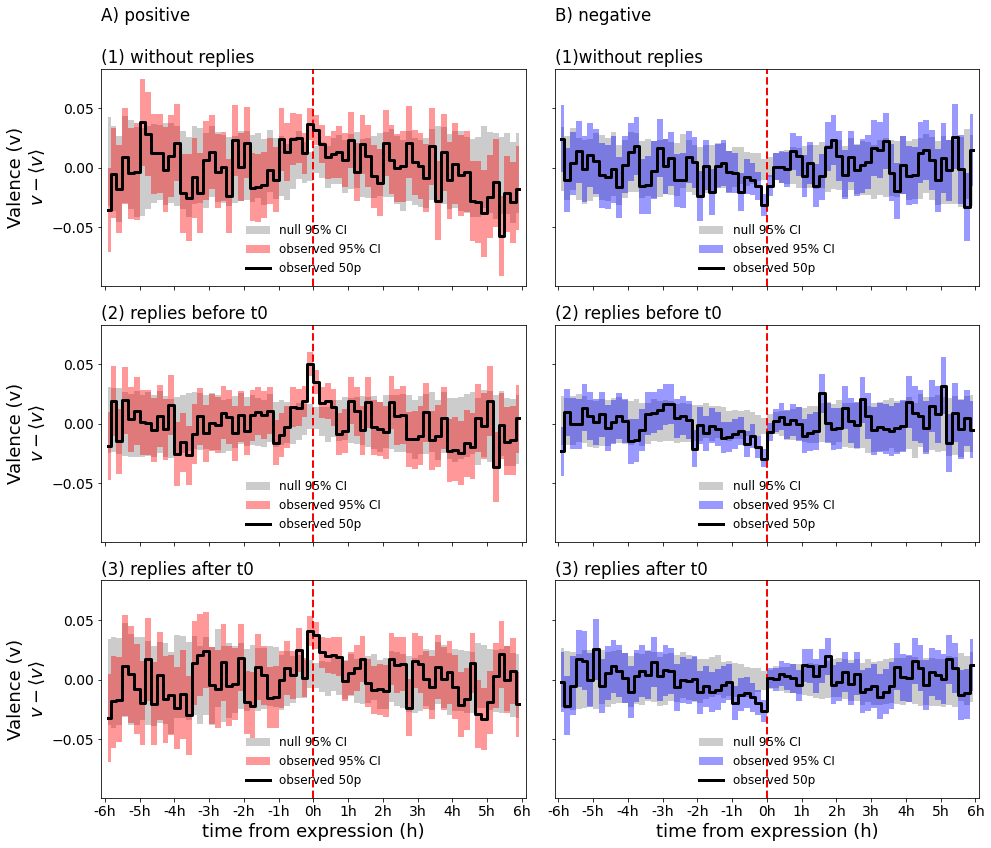

In [12]:

files = ['pos_reply_status=none.txt',\
         'neg_reply_status=none.txt',\
         'pos_reply_status=before.txt',\
         'neg_reply_status=before.txt',\
        "pos_reply_status=after.txt",\
        "neg_reply_status=after.txt"]

pos_none = pd.read_csv(DATA_PATH+files[0], sep="\t")
neg_none= pd.read_csv(DATA_PATH+files[1], sep="\t")
pos_before= pd.read_csv(DATA_PATH+files[2], sep="\t")
neg_before = pd.read_csv(DATA_PATH+files[3], sep="\t")
pos_after= pd.read_csv(DATA_PATH+files[4], sep="\t")
neg_after= pd.read_csv(DATA_PATH+files[5], sep="\t")

plt.rcParams['figure.figsize'] = (14.0, 12.0)
plt.rcParams.update({'font.size': 14})
plt.rcParams["legend.loc"] = 'lower center' 
datasets = [pos_none, neg_none, pos_before, neg_before,pos_after,neg_after]

labels = ["A) positive\n\n(1) without replies", "B) negative\n\n(1)without replies",
          "(2) replies before t0",   "(2) replies before t0",
         "(3) replies after t0", "(3) replies after t0"]

fig, axes = plt.subplots(3, 2, sharex=True, sharey=True)
for i, ax in enumerate([axes[0][0], axes[0][1],  axes[1][0], axes[1][1], axes[2][0], axes[2][1]]):        
    # get next data file from files and labels, and plot these in the present ax in axes
    data = datasets[i]
    label = labels[i]
    color = ['red' if i % 2 ==0  else 'blue']
    
    # Mean difference
    meanVader = data["vader_50p"].mean()
    data["vader_50p"] -= meanVader
    data["vader_2.5p"] -= meanVader
    data["vader_97.5p"] -= meanVader
    meanNull = data["null_50p"].mean()
    data["null_50p"] -= meanNull
    data["null_2.5p"] -= meanNull
    data["null_97.5p"] -= meanNull
    print('[{}] Vader mean:{:.2f} | Null mean:{:.2f}'.format(label, meanVader, meanNull))
    
    # get index of maximum value
    maxv = np.argmax(data["vader_50p"].values)
    minv = np.argmin(data["vader_50p"].values)
    
    #### EMOTIONAL PERIOD BASED ON NON-OVERLAPPING CI
    # find area where CIs don't overlap, i.e. where vader_2.5p > null_97.5p
    # or where vader_97.5p < null_2.5p
    print(label, "\n")
    data["upper"] = data["vader_2.5p"] - data["null_97.5p"]
    data["lower"] = data["vader_97.5p"] - data["null_2.5p"]
    print("> NULL:\n", data[data["upper"] > 0]["window"])
    print("< NULL\n", data[data["lower"] < 0.001]["window"])

    # set up graph labels and axes
    ax.set_title(label, loc="left")
    
    ax.axvline(x=0, color="red", linestyle="--", linewidth=2)
    if i in [0,2,4]:
        ax.set_ylabel("Valence (v)\n" + r"$v - \left \langle v \right \rangle$", fontsize=18)
    if i in [4,5]:
        ax.set_xlabel("time from expression (h)", fontsize=18)
    
    plt.sca(ax)
    plt.xticks([i*60*60 for i in range(-6,7)], [str(i)+'h' for i in range(-6,7)])
    
    # null bands and lines
    ax.fill_between(data["window"], data["null_2.5p"], data["null_97.5p"],
                    alpha=0.4, facecolor='gray', label="null 95% CI", step="mid")

    # valence bands and lines
    ax.fill_between(data["window"], data["vader_2.5p"], data["vader_97.5p"],
                    alpha=0.4, facecolor=color[0], label="observed 95% CI", step="mid")
    ax.step(data["window"], data["vader_50p"], color="black",
            linewidth=3, label="observed 50p", where="mid")
    #ax.grid(which='both')
    ax.set_xlim([-22000, +22000])
    ax.legend(frameon=False, prop={'size': 12})                 

plt.tight_layout()
fig.savefig('%sfigures/posneg_reply_status_10min_step.pdf' % DATA_PATH, bbox_inches='tight')
# fig.savefig('figures/Fig6.pdf', bbox_inches='tight')


[A) positive

(1) replies before t0] Vader mean:0.13 | Null mean:0.13
A) positive

(1) replies before t0 

> NULL:
 35   -300
36    300
Name: window, dtype: int64
< NULL
 Series([], Name: window, dtype: int64)
[B) negative

(1)replies before t0] Vader mean:0.11 | Null mean:0.11
B) negative

(1)replies before t0 

> NULL:
 Series([], Name: window, dtype: int64)
< NULL
 34   -900
35   -300
Name: window, dtype: int64
[(2) replies before t0 with replies after t0] Vader mean:0.13 | Null mean:0.13
(2) replies before t0 with replies after t0 

> NULL:
 35   -300
36    300
Name: window, dtype: int64
< NULL
 Series([], Name: window, dtype: int64)
[(2) replies before t0 with replies after t0] Vader mean:0.11 | Null mean:0.11
(2) replies before t0 with replies after t0 

> NULL:
 Series([], Name: window, dtype: int64)
< NULL
 35   -300
Name: window, dtype: int64
[(3) replies before t0 without replies after t0] Vader mean:0.12 | Null mean:0.13
(3) replies before t0 without replies after t0 

> NUL

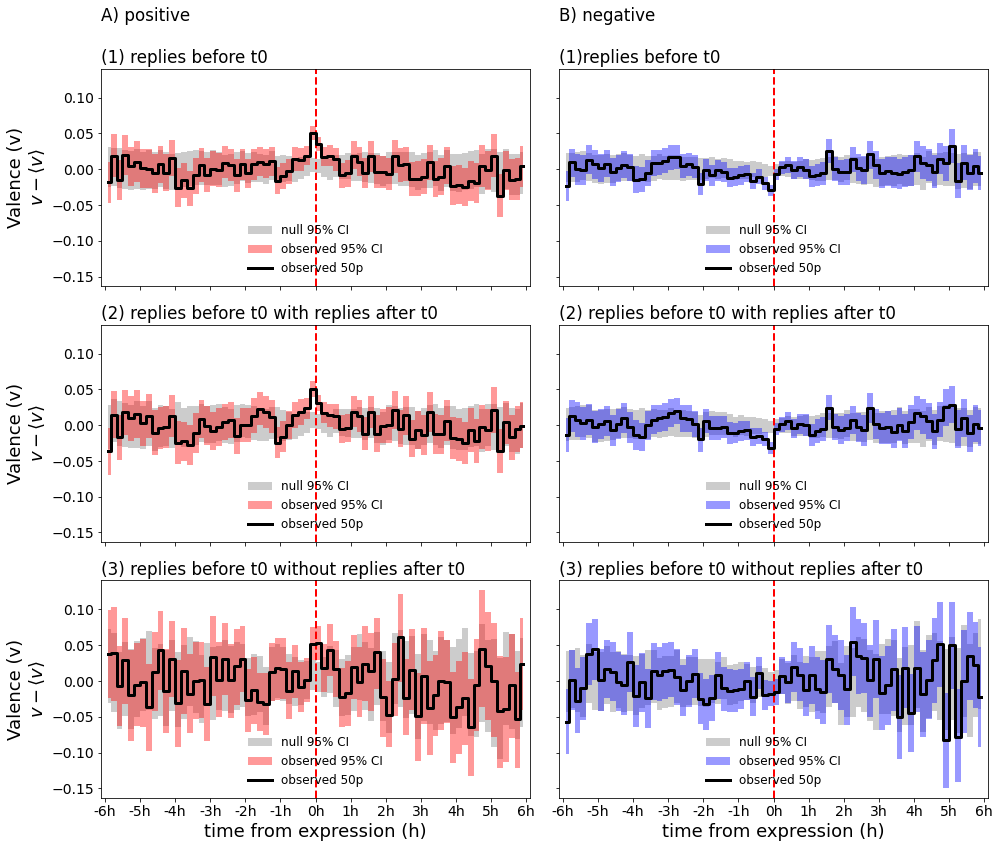

In [197]:

files = ['pos_reply_status=before.txt',\
         'neg_reply_status=before.txt',\
         'pos_reply_status=before_after.txt',\
         'neg_reply_status=before_after.txt',\
        "pos_reply_status=before_noafter.txt",\
        "neg_reply_status=before_noafter.txt"]

pos_none = pd.read_csv(DATA_PATH+files[0], sep="\t")
neg_none= pd.read_csv(DATA_PATH+files[1], sep="\t")
pos_before= pd.read_csv(DATA_PATH+files[2], sep="\t")
neg_before = pd.read_csv(DATA_PATH+files[3], sep="\t")
pos_after= pd.read_csv(DATA_PATH+files[4], sep="\t")
neg_after= pd.read_csv(DATA_PATH+files[5], sep="\t")

plt.rcParams['figure.figsize'] = (14.0, 12.0)
plt.rcParams.update({'font.size': 14})
plt.rcParams["legend.loc"] = 'lower center' 
datasets = [pos_none, neg_none, pos_before, neg_before,pos_after,neg_after]

labels = ["A) positive\n\n(1) replies before t0", "B) negative\n\n(1)replies before t0",
          "(2) replies before t0 with replies after t0",   "(2) replies before t0 with replies after t0",
         "(3) replies before t0 without replies after t0",   "(3) replies before t0 without replies after t0"]

fig, axes = plt.subplots(3, 2, sharex=True, sharey=True)
for i, ax in enumerate([axes[0][0], axes[0][1],  axes[1][0], axes[1][1], axes[2][0], axes[2][1]]):        
    # get next data file from files and labels, and plot these in the present ax in axes
    data = datasets[i]
    label = labels[i]
    color = ['red' if i % 2 ==0  else 'blue']
    
    # Mean difference
    meanVader = data["vader_50p"].mean()
    data["vader_50p"] -= meanVader
    data["vader_2.5p"] -= meanVader
    data["vader_97.5p"] -= meanVader
    meanNull = data["null_50p"].mean()
    data["null_50p"] -= meanNull
    data["null_2.5p"] -= meanNull
    data["null_97.5p"] -= meanNull
    print('[{}] Vader mean:{:.2f} | Null mean:{:.2f}'.format(label, meanVader, meanNull))
    
    # get index of maximum value
    maxv = np.argmax(data["vader_50p"].values)
    minv = np.argmin(data["vader_50p"].values)
    
    #### EMOTIONAL PERIOD BASED ON NON-OVERLAPPING CI
    # find area where CIs don't overlap, i.e. where vader_2.5p > null_97.5p
    # or where vader_97.5p < null_2.5p
    print(label, "\n")
    print("> NULL:\n", data[data["vader_2.5p"] > data["null_97.5p"]]["window"])
    print("< NULL\n", data[data["vader_97.5p"] < data["null_2.5p"]]["window"])

    # set up graph labels and axes
    ax.set_title(label, loc="left")
    
    ax.axvline(x=0, color="red", linestyle="--", linewidth=2)
    if i in [0,2,4]:
        ax.set_ylabel("Valence (v)\n" + r"$v - \left \langle v \right \rangle$", fontsize=18)
    if i in [4,5]:
        ax.set_xlabel("time from expression (h)", fontsize=18)
    
    plt.sca(ax)
    plt.xticks([i*60*60 for i in range(-6,7)], [str(i)+'h' for i in range(-6,7)])
    
    # null bands and lines
    ax.fill_between(data["window"], data["null_2.5p"], data["null_97.5p"],
                    alpha=0.4, facecolor='gray', label="null 95% CI", step="mid")

    # valence bands and lines
    ax.fill_between(data["window"], data["vader_2.5p"], data["vader_97.5p"],
                    alpha=0.4, facecolor=color[0], label="observed 95% CI", step="mid")
    ax.step(data["window"], data["vader_50p"], color="black",
            linewidth=3, label="observed 50p", where="mid")
    #ax.grid(which='both')
    ax.set_xlim([-22000, +22000])
    ax.legend(frameon=False, prop={'size': 12})                 

plt.tight_layout()
fig.savefig('%sfigures/posneg_reply_status_10min_step_supply.pdf' % DATA_PATH, bbox_inches='tight')
# fig.savefig('figures/Fig6.pdf', bbox_inches='tight')
